In [1]:
# 15-Sep-2019
# Bo Milvang-Jensen
# Very rudimentary script to read+plot ...

import astropy.io.fits as fits
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import theano
import theano.tensor as tt
from theano.tensor import fft
import theano.tensor.signal.conv

# Read photometry catalogue created by my other script
photfilename = 'F51_out_REMIR_ROS2.fits'
data = fits.getdata(photfilename, 1)

# The photometry catalogue contains aperture photometry in 25 different
# apertures. If we number them 0..24, they correspond to diameters 1..25 arcsec
apno = 10 # This is then 11 arcsec

# The photometry catalogue contains photometry for the AGN plus some more
# objects in the field, in this case the AGN + 6 more objetcs, so 7 in
# total. The AGN is number 1, and the others 2, 3, etc.
# This is seen in the column names, which end in _1, _2, etc.
# E.g. the column MAG_APER_1 contains the aperture magnitudes (for all
# 25 apertures) for the AGN.

# Get the aperture magnitudes
##foo = data['MAG_APER_1'] # has shape e.g. (767, 25), the 25 being the apertures
mag_agn  = data['MAG_APER_1'][:,apno]
mag_ref1 = data['MAG_APER_3'][:,apno] # I have found that _3 is good here
mag_ref2 = data['MAG_APER_4'][:,apno]

# Get the differential magnitudes
delta_mag_agn_ref1 = mag_agn - mag_ref1
delta_mag_ref2_ref1 = mag_ref2 - mag_ref1

# Get the magnitude errors 
magerr_agn = data['MAGERR_APER_1'][:,apno]
magerr_ref1 = data['MAGERR_APER_3'][:,apno]
magerr_ref2= data['MAGERR_APER_4'][:,apno]

# TODO Here I could loop over the filters, subtracting the median

# For simplicity "extract" some arrays from the data
filt = data['filter']
mjd_obs = data['mjd_obs']

# A simple plot of the J band differential mags, with the median subtracted
# Do 'H' and 'K' in the same way
maskJ = (filt == 'J')
#print(magerr_ref1[mask])
#plt.scatter(mjd_obs[mask], delta_mag_agn_ref1[mask]-np.median(delta_mag_agn_ref1[mask]))
plt.errorbar(mjd_obs[maskJ], delta_mag_agn_ref1[maskJ]-np.median(delta_mag_agn_ref1[maskJ]), magerr_ref1[maskJ],fmt='b.')
plt.title('test')
plt.xlabel('MJD-OBS')
plt.ylabel('delta mag')
plt.show()

<Figure size 640x480 with 1 Axes>

In [2]:
#J band data
xJ=np.asarray(mjd_obs[maskJ], dtype=float)
nJ=len(xJ)
XJ = np.reshape(xJ,(nJ,1))
yJ=np.asarray(delta_mag_agn_ref1[maskJ]-np.median(delta_mag_agn_ref1[maskJ]), dtype=float)
yJerr = np.array(magerr_ref1[maskJ], dtype=float)

#H band data
maskH = (filt == 'H')

xHtemp=np.asarray(mjd_obs[maskH], dtype=float)
xH=np.delete(xHtemp,(1,2))
nH=len(xH)
XH = np.reshape(xH,(nH,1))
XH_new=np.linspace(min(XH),max(XH),100,dtype=np.float64)

Hdelta_mag_agn_ref1=np.delete(delta_mag_agn_ref1[maskH],(1,2))
yH=np.asarray(Hdelta_mag_agn_ref1-np.median(Hdelta_mag_agn_ref1), dtype=float)
yHerrtemp = np.asarray(magerr_ref1[maskH], dtype=float)
yHerr=np.delete(yHerrtemp,(1,2))

#K band data
maskK = (filt == 'K')
xK=np.asarray(mjd_obs[maskK], dtype=float)
nK=len(xK)
XK = np.reshape(xK,(nK,1))
yK=np.asarray(delta_mag_agn_ref1[maskK]-np.median(delta_mag_agn_ref1[maskK]), dtype=float)
yKerr = np.asarray(magerr_ref1[maskK], dtype=float)

#time array with all bands
#be carefull with how XJ and xj acts 
X_tot= np.concatenate((xJ,xH,xK),axis=None)
X_tot=np.reshape(X_tot,(len(X_tot),1))

#combine all y values for guess
Y_tot= np.concatenate((yJ,yH,yK),axis=None)
Y_tot=np.reshape(Y_tot,(len(Y_tot),1))

#time delay array
tau=np.linspace(1.0,100.0,99)
tau=np.reshape(tau,(1,1,99,1))
print(np.mean(yK))

0.01194034152560764


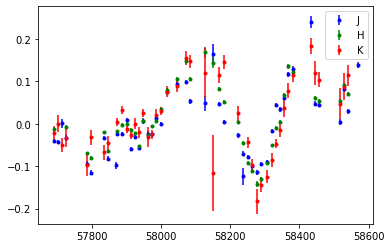

In [3]:
plt.errorbar(xJ, yJ, yJerr,fmt='b.',label='J')
plt.errorbar(xH, yH, yHerr,fmt='g.',label='H')
plt.errorbar(xK, yK, yKerr,fmt='r.',label='K')
plt.legend()

In [4]:
with pm.Model() as convmodel:
    
    #define driving function as Gaussian Process
    #find way to use g band as first guess of value 
    ℓ = pm.Uniform('ℓ', lower=0.0, upper=tt.sqrt(70.0))#pm.Bound(pm.Normal, lower=1.2574, upper=3.0*50.0*np.sqrt(2.0))('ℓ', mu=70.0, sigma=35.0)#timescale of variation for the driving function
    η = pm.Uniform('η', lower=0.0, upper=0.5)#long term standard deviation for the driving function
    cov = η**2 * pm.gp.cov.Exponential(1, ℓ)#using same cov as light curve interpolation
    const_func = pm.gp.mean.Constant(tt.mean(yJ))#long term mean. Should it be zero or the g-band value?
    gp = pm.gp.Latent(cov_func=cov, mean_func=const_func)
    f = gp.prior("f", X=X_tot)#has all time values for all bands, testval is for g-band diffmag values?
    f = f.reshape((1,1,len(X_tot),1))
    #print(len(f.tag.test_value[0,0,:,0]))
    #print(f.tag.test_value)
    
    
    #Define priors
    
    #Universal Dusty Torus parameters for the uniform temperature DT
    sigma_DT=pm.Uniform('sigma_DT', lower=tt.log(1.1), upper=tt.log(25.0))#needs a source for scale
    m_DT=pm.Uniform('m_DT', lower=2.0, upper=150.0)#we expect serveral tens to hundreds of days
    theta_DT=pm.Uniform('theta_DT', lower=0.0, upper=np.max(tau)/1.2)#add later when simple model is staple
    
    #Accretion Disk paramters
    Jsigma_AD=pm.Bound(pm.Normal, lower=1.1, upper=25.0)('Jsigma_AD', mu=7.5,sigma=4.0)#pm.Uniform('Jsigma_AD', lower=tt.log(1.1), upper=tt.log(25.0))#needs a source for scale
    Jsigma_AD=tt.log(Jsigma_AD)
    Jm_AD=pm.Uniform('Jm_AD', lower=2.0, upper=50.0)#AD has 3-5 times smaller lags than DT 
    Jtheta_AD=pm.Uniform('Jtheta_AD', lower=0.0, upper=np.max(tau)/1.2)#add later 
   
    Hsigma_AD=pm.Bound(pm.Normal, lower=1.1, upper=25.0)('Hsigma_AD',mu=10.0,sigma=6.0)#pm.Uniform('Hsigma_AD', lower=tt.log(1.1), upper=tt.log(25.0))#needs a source for scale
    Hsigma_AD=tt.log(Hsigma_AD)
    Hm_AD=pm.Uniform('Hm_AD', lower=2.0, upper=50.0)#AD has 3-5 times smaller lags than DT
    Htheta_AD=pm.Uniform('Htheta_AD', lower=0.0, upper=np.max(tau)/1.2)#add later 
    
    Ksigma_AD=pm.Bound(pm.Normal, lower=1.1, upper=25.0)('Ksigma_AD',mu=10.5,sigma=8.0)#pm.Uniform('Ksigma_AD', lower=tt.log(1.1), upper=tt.log(25.0))#needs a source for scale
    Ksigma_AD=tt.log(Ksigma_AD)
    Km_AD=pm.Uniform('Km_AD', lower=2.0, upper=50.0)#AD has 3-5 times smaller lags than DT
    Ktheta_AD=pm.Uniform('Ktheta_AD', lower=0.0, upper=np.max(tau)/1.2)#add later 
    
    #BB and power law parameters
    T=pm.Bound(pm.Normal, lower=1000.0, upper=2000.0)('T', mu=1400.0, sigma=100.0)#taken from nature letter
    K_0=pm.Uniform('K_0', lower=0.0, upper=10.0)#is it BB/powr or powr/BB?
    index=pm.Uniform('index', lower=0.0, upper=3.0)#sign depends on diffmag definition change to -2 to -1 for final?

    #Different wavelength for different bands, not a free paramter 
    #REMIR filters in nm NEED DATASHEET
    Jwav=1250.0
    Hwav=1625.0
    Kwav=2150.0
    #Sloan filters for ROSS2 in nm
    #gwav=475.4
    #rwav= 620.4
    #iwav=769.8
    #zwav=966.5
    

    #Define constants 
    wav_0 = 1000.0#Reference wavelength in nm, use 500?
    h = 6.626e-34#Plancks constant in J*s
    c = 299792458.0#speed of light in m/s
    k = 1.38e-23#Boltzmanns constant in J/K
    
    #peak Black Body from uniform torus temperature
    wav_peak = 2.898*10**6/T
    b_max = h*c/(1e-9*wav_peak*k*T)
    BB_max = 1.0/( (wav_peak**5) * (tt.exp(b_max) - 1.0) )
    
    #Universal lognormal for Dusty Torus 
    exp_DT = -((tt.log((tau-theta_DT)/m_DT))**2/(2*sigma_DT**2)) 
    front_DT = 1.0/((tau-theta_DT)*sigma_DT*np.sqrt(2*np.pi))
    lognorm_DT = front_DT*tt.exp(exp_DT)
    lognorm_DT = tt.switch(tt.isnan(lognorm_DT), 0.0, lognorm_DT)
    
    #Dusty Torus transfer equation for J band
    Jb = h*c/(1e-9*Jwav*k*T)
    JBB = (1.0/( Jwav**5 * (tt.exp(Jb) - 1.0) ))/BB_max
    JPsi_DT = JBB*lognorm_DT
    
    #Dusty Torus transfer equation for H band
    Hb = h*c/(1e-9*Hwav*k*T)
    HBB = (1.0/( Hwav**5 * (tt.exp(Hb) - 1.0) ))/BB_max
    HPsi_DT = HBB*lognorm_DT
    
    #Dusty Torus transfer equation for K band
    Kb = h*c/(1e-9*Kwav*k*T)
    KBB = (1.0/( Kwav**5 * (tt.exp(Kb) - 1.0) ))/BB_max
    KPsi_DT = KBB*lognorm_DT
    
    #Accretion Disk transfer equation for the J band
    Jpowr = K_0*(Jwav/wav_0)**(index)    
    Jexp_AD = -((tt.log((tau-Jtheta_AD)/Jm_AD)-Jsigma_AD**2)**2/(2*Jsigma_AD**2))
    Jfront_AD = 1.0/((tau-Jtheta_AD)*Jsigma_AD*np.sqrt(2*np.pi))
    Jlognorm_AD = Jfront_AD*tt.exp(Jexp_AD)
    Jlognorm_AD = tt.switch(tt.isnan(Jlognorm_AD), 0.0, Jlognorm_AD)
    JPsi_AD = Jpowr*Jlognorm_AD
    
    #Accretion Disk transfer equation for the H band
    Hpowr = K_0*(Hwav/wav_0)**(index)    
    Hexp_AD = -((tt.log((tau-Htheta_AD)/Hm_AD)-Hsigma_AD**2)**2/(2*Hsigma_AD**2))
    Hfront_AD = 1.0/((tau-Htheta_AD)*Hsigma_AD*np.sqrt(2*np.pi))
    Hlognorm_AD = Hfront_AD*tt.exp(Hexp_AD)
    Hlognorm_AD = tt.switch(tt.isnan(Hlognorm_AD), 0.0, Hlognorm_AD)
    HPsi_AD = Hpowr*Hlognorm_AD
    
    #Accretion Disk transfer equation for the K band
    Kpowr = K_0*(Kwav/wav_0)**(index)    
    Kexp_AD = -((tt.log((tau-Ktheta_AD)/Km_AD)-Ksigma_AD**2)**2/(2*Ksigma_AD**2))
    Kfront_AD = 1.0/((tau-Ktheta_AD)*Ksigma_AD*np.sqrt(2*np.pi))
    Klognorm_AD = Kfront_AD*tt.exp(Kexp_AD)
    Klognorm_AD = tt.switch(tt.isnan(Klognorm_AD), 0.0, Klognorm_AD)
    KPsi_AD = Kpowr*Klognorm_AD
    
    #Full transfer equations
    Jtransfer = JPsi_DT + JPsi_AD
    Htransfer = HPsi_DT + HPsi_AD
    Ktransfer = KPsi_DT + KPsi_AD
    
    #The convolutions
    #filter needs to be odd so tau is odd
    Jconvol=theano.tensor.nnet.conv2d(f[:,:,0:len(xJ),:],Jtransfer,border_mode='half')
    Hconvol=theano.tensor.nnet.conv2d(f[:,:,len(xJ):len(xJ)+len(xH),:],Htransfer,border_mode='half')
    Kconvol=theano.tensor.nnet.conv2d(f[:,:,len(xJ)+len(xH):len(xJ)+len(xH)+len(xK),:],Ktransfer,border_mode='half')

    #Define likelihoods
    #k = pm.Uniform('k', lower=1.0, upper=10.0)#Noise boost factor 
    Jlikelihood = pm.Normal('yJ', mu=Jconvol[0,0,:,0], sigma=yJerr, observed=yJ)
    Hlikelihood = pm.Normal('yH', mu=Hconvol[0,0,:,0], sigma=yHerr, observed=yH)
    Klikelihood = pm.Normal('yK', mu=Kconvol[0,0,:,0], sigma=yKerr, observed=yK)
    #the shape of mu and observed needs to be the same 
    
    tracetransfer = pm.sample(1,tune=600, discard_tuned_samples=False)

Only 1 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Malte\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
C:\Users\Malte\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
C:\Users\Malte\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprec

RuntimeError: Chain 0 failed.

In [ ]:
names=['index', 'K_0', 'T', 'Km_AD', 'Ksigma_AD', 'sigma_DT', 'Hm_AD', 'theta_DT', 'm_DT', 'Hsigma_AD', 'Jm_AD', 'Jsigma_AD', 'η', 'ℓ']
# display the total number and percentage of divergent
divergent = tracetransfer['diverging']
print('Number of Divergent %d' % divergent.nonzero()[0].size)
divperc = (divergent.nonzero()[0].size / (2*len(tracetransfer))) * 100
print('Percentage of Divergent %.1f' % divperc)

In [ ]:
from collections import defaultdict
divergent_point = defaultdict(list)

chain_warn = tracetransfer.report._chain_warnings
for i in range(len(chain_warn)):
    for warning_ in chain_warn[i]:
        if warning_.step is not None and warning_.extra is not None:
            for RV in convmodel.free_RVs:
                para_name = RV.name
                divergent_point[para_name].append(warning_.extra[para_name])

for RV in convmodel.free_RVs:
    para_name = RV.name
    divergent_point[para_name] = np.asarray(divergent_point[para_name])


In [ ]:
tracedf = pm.trace_to_dataframe(tracetransfer)
plotorder = names
tracedf = tracedf[plotorder]

_, ax = plt.subplots(1, 2, figsize=(15, 4), sharex=True, sharey=True)
ax[0].plot(tracedf.values[divergent == 0].T, color='k', alpha=.025)
ax[0].plot(tracedf.values[divergent == 1].T, color='C2', lw=.5)

ax[1].plot(tracedf.values[divergent == 0].T, color='k', alpha=.025)
ax[1].plot(tracedf.values[divergent == 1].T, color='C2', lw=.5)
divsp = np.hstack([divergent_point['Km_AD_interval__'][:,None],
                  ])

ax[1].plot(divsp.T, 'C3', lw=.5)
plt.ylim([-20,40])
plt.xticks(range(10), plotorder)
plt.tight_layout();

In [ ]:
pm.summary(tracetransfer, names).round(2)

In [ ]:
pm.traceplot(tracetransfer, var_names=names);

In [ ]:
pm.plot_posterior(tracetransfer,names)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

mu,sigma,n = 7.5,5.,1000

def normal(x,mu,sigma):
    return ( 2.*np.pi*sigma**2. )**-.5 * np.exp( -.5 * (x-mu)**2. / sigma**2. )

x = np.random.normal(mu,sigma,n) 
y = normal(x,mu,sigma) 


plt.plot(x,y,'.')

In [ ]:
3.0*50.0*np.sqrt(2.0)